In [101]:
import lightfm
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm.data import Dataset
from sklearn.model_selection import train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from scipy.sparse import csr_matrix

In [4]:
# Read in yelp.parquet
business = pd.read_feather('FilteredData/business_philly.feather')
review = pd.read_feather('FilteredData/review_philly.feather')
user = pd.read_feather('FilteredData/user_philly.feather')

Prepare the data

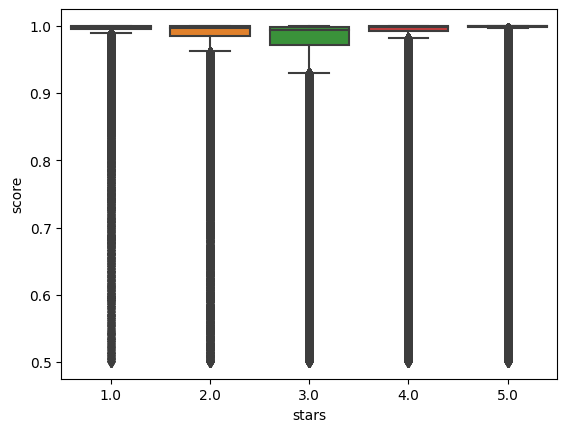

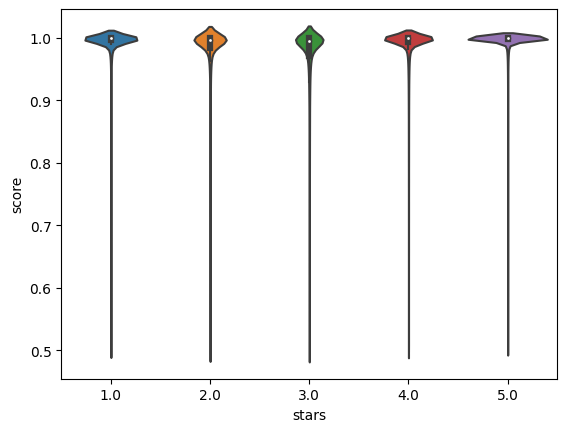

In [ ]:
distilbert = pd.read_csv('Sentiment Analysis/distilbert/sentiment_results_distilbert.csv')
sns.boxplot(x = 'stars',y='score',data = distilbert)
plt.show()
sns.violinplot(x = 'stars',y='score',data = distilbert)
plt.show()

### Experiment 1: AUC of full philly dataset

In [11]:
dataset = Dataset()
dataset.fit(
    (row['user_id'] for _, row in review.iterrows()),
    (row['business_id'] for _, row in review.iterrows()))

In [18]:
# Add interactions
train, test = train_test_split(review, test_size=0.2)
# Build test interactions
test_interactions, test_weights = dataset.build_interactions(
    ((row['user_id'], row['business_id'], row['stars']) for _, row in test.iterrows()))
# Build train interactions
train_interactions, train_weights = dataset.build_interactions(
    ((row['user_id'], row['business_id'], row['stars']) for _, row in train.iterrows()))

In [31]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

# Instantiate and train the model
model = lightfm.LightFM()
model.fit(train_interactions, epochs=30, num_threads=4)

In [32]:
%%time
train_auc = auc_score(model, test_interactions).mean()
print(f'Train AUC: {train_auc:.2f}')

Train AUC: 0.85
CPU times: user 29.8 s, sys: 83 µs, total: 29.8 s
Wall time: 29.8 s


## Include Categories

In [37]:
# Read dilbert data
##time
distilbert = pd.read_csv('Sentiment Analysis/distilbert/sentiment_results_distilbert.csv')

In [49]:
business.head()

,index,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,31,631ea3b2a5cde8cc0d6eec47,-0M0b-XhtFagyLmsBtOe8w,Paris Wine Bar,2303 Fairmount Ave,Philadelphia,PA,19130,39.967439,-75.175452,3.5,18,0,"{'Alcohol': ""u'full_bar'"", 'OutdoorSeating': '...","Bars, Nightlife, Restaurants, French, Wine Bars","{'Thursday': '17:0-0:0', 'Friday': '17:0-0:0',..."
1,32,631ea3b0a5cde8cc0d6dfa60,-0PN_KFPtbnLQZEeb23XiA,Mr Wong's Chinese Restaurant,1849 Wolf St,Philadelphia,PA,19145,39.923048,-75.178078,3.5,9,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Chinese","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
2,33,631ea3aea5cde8cc0d6d5a50,-0TffRSXXIlBYVbb5AwfTg,IndeBlue Modern Indian Food & Spirits,205 South 13th St,Philadelphia,PA,19107,39.948508,-75.161969,4.5,1097,1,"{'RestaurantsReservations': 'True', 'NoiseLeve...","Cocktail Bars, Food Delivery Services, Nightli...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-22:0', ..."
3,37,631ea3b0a5cde8cc0d6e2ef1,-0eUa8TsXFFy0FCxHYmrjg,Waterfront Gourmet Cafe & Deli,3131 Walnut St,Philadelphia,PA,19104,39.952446,-75.187321,4.0,26,0,"{'BikeParking': 'True', 'RestaurantsGoodForGro...","Caterers, Sandwiches, Delis, Restaurants, Cafe...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,40,631ea3ada5cde8cc0d6d26c0,-0fvhILrC9UsQ6gLNpZlTQ,David's Southern Fried Pies,8601 Frankford Ave,Philadelphia,PA,19136,40.046191,-75.015090,4.5,18,0,"{'BusinessAcceptsBitcoin': 'False', 'Caters': ...","Desserts, Food","{'Monday': '0:0-0:0', 'Tuesday': '12:0-19:0', ..."


In [71]:
# Create set of all categories
all_cats = set
cat_list = business.categories.apply(lambda x: x.split(", "))
for row in cat_list:
    for cat in row:
        all_cats.add(cat)
print(f'Found {len(all_cats)} unique categories')

Found 803 unique categories


In [94]:
# Create a list of dictionaries
## Following: https://github.com/kapadias/mediumposts/blob/master/recommender/published_notebooks/recommendation_python_lightfm.ipynb
business_category_list = []

for i in range(len(cat_list)):
    this_biz = {}
    for cat in all_cats:
        contains = cat in cat_list[i]
        this_biz[cat] = contains
    business_category_list.append(this_biz)
business_cat_df = pd.DataFrame(business_category_list)
business_cat_df.head()

,1,2,3,Breweries,Supernatural Readings,Grill Services,Empanadas,Body Contouring,Radio Stations,Home Organization,...,CPR Classes,Coffee Roasteries,Irish,Beer Tours,Shades & Blinds,Cajun/Creole,Beer Hall,Painters,Preschools,Pawn Shops
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [97]:
# Add bookid and back to original then turn to csr matrix
business_cat_df['business_id'] = business['business_id']

In [100]:
business_cat_df.set_index('business_id', inplace=True)

In [103]:
business_cat_matrix = csr_matrix(business_cat_df)

In [105]:
business_cat_matrix

<10391x803 sparse matrix of type '<class 'numpy.bool_'>'
	with 47792 stored elements in Compressed Sparse Row format>